In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pyomo.environ import *
from random import uniform

# Загрузка данных

In [2]:
with open('product_rels.pkl', 'rb') as file:
    product_rels = pickle.load(file)
    
with open('shop_info.pkl', 'rb') as file:
    shop_info = pickle.load(file)
    
prices = pd.read_csv('prices.csv')

In [3]:
prices.head()

,year_week,start_weekday,price_apple,price_banana,price_pear,price_orange,price_lemon
0,201931,2019-07-29,90.0,80.0,130.0,100.0,110.0
1,201932,2019-08-05,90.0,80.0,130.0,100.0,110.0
2,201933,2019-08-12,90.0,80.0,130.0,100.0,110.0
3,201934,2019-08-19,90.0,80.0,130.0,100.0,110.0
4,201935,2019-08-26,90.0,80.0,130.0,100.0,110.0


In [4]:
product_rels

{('apple', 'apple'): 0,
 ('apple', 'banana'): 0.15,
 ('apple', 'pear'): -0.15,
 ('apple', 'orange'): 0.17,
 ('apple', 'lemon'): 0.17,
 ('banana', 'apple'): 0.15,
 ('banana', 'banana'): 0,
 ('banana', 'pear'): 0.12,
 ('banana', 'orange'): 0.1,
 ('banana', 'lemon'): 0.1,
 ('pear', 'apple'): -0.15,
 ('pear', 'banana'): 0.12,
 ('pear', 'pear'): 0,
 ('pear', 'orange'): 0.12,
 ('pear', 'lemon'): 0.12,
 ('orange', 'apple'): 0.17,
 ('orange', 'banana'): 0.1,
 ('orange', 'pear'): 0.12,
 ('orange', 'orange'): 0,
 ('orange', 'lemon'): -0.19,
 ('lemon', 'apple'): 0.17,
 ('lemon', 'banana'): 0.1,
 ('lemon', 'pear'): 0.12,
 ('lemon', 'orange'): -0.19,
 ('lemon', 'lemon'): 0}

In [5]:
shop_info

{0: {'shop_id': '0c82a0ea628e0ec608d70d1db9d822d9',
  'shop_size_coef': 1,
  'apple': 825.0,
  'banana': 309.0,
  'pear': 416.0,
  'orange': 522.0,
  'lemon': 571.0},
 1: {'shop_id': '0e0b24fc303d2b384be5a2464654a5d2',
  'shop_size_coef': 1,
  'apple': 618.0,
  'banana': 358.0,
  'pear': 459.0,
  'orange': 460.0,
  'lemon': 657.0},
 2: {'shop_id': '0e7e3cf0ded4d9db8b376b317c007f99',
  'shop_size_coef': 2,
  'apple': 2144.0,
  'banana': 1020.0,
  'pear': 1147.0,
  'orange': 1660.0,
  'lemon': 1599.0},
 3: {'shop_id': '155d328d7db586cf215aca5e8088dfed',
  'shop_size_coef': 2,
  'apple': 727.0,
  'banana': 349.0,
  'pear': 418.0,
  'orange': 556.0,
  'lemon': 437.0},
 4: {'shop_id': '1640f59af9fc45f93a72652de254d387',
  'shop_size_coef': 1,
  'apple': 667.0,
  'banana': 272.0,
  'pear': 409.0,
  'orange': 556.0,
  'lemon': 634.0},
 5: {'shop_id': '171293841d3fdd4af2e12426ce202ac9',
  'shop_size_coef': 2,
  'apple': 2067.0,
  'banana': 911.0,
  'pear': 1288.0,
  'orange': 1366.0,
  'lemon'

In [6]:
prices = prices.head(24)

In [7]:
products = ['apple', 'banana', 'pear', 'orange', 'lemon']

In [8]:
S = len(shop_info)
W = 24
P = len(products)

# Оптимизация с помощью Pyomo

In [9]:
def L(s: int, p: int, w: int, R: list) -> float:
    result = 0
    for o in range(p):
        r_ow = R[o][w]
        r_ow_seasonal = prices.loc[w][f'price_{products[o]}']
        C_po = product_rels[(products[p], products[o])]
        M_so = shop_info[s][products[o]]
        result += (r_ow_seasonal / r_ow) ** 2 * C_po * M_so
    return result

In [10]:
def f(s: int, p: int, w: int, R: list) -> float:
    r_pw = R[p][w]
    M_sp = shop_info[s][products[p]]
    r_pw_seasonal = prices.loc[w][f'price_{products[p]}']
    L_spw = L(s, p, w, R)
    return r_pw * (M_sp * (-(r_pw / r_pw_seasonal) ** 2 - 0.075 * r_pw / r_pw_seasonal + 2.85) / 1.775 + L_spw)

In [11]:
def optimize_prices() -> list: # возвращает матрицу цен
    
    def var_matrix_to_list(var: Var, dim1: int, dim2: int) -> list:
        return [[var[i, j] for j in range(1, dim2 + 1)] for i in range(1, dim1 + 1)]
    
    model = ConcreteModel()
    
    model.r = Var(range(1, P + 1), range(1, W + 1), domain=PositiveIntegers)
    
    model.objective = Objective(
        expr=quicksum(quicksum(quicksum(f(s, p, w, var_matrix_to_list(model.r, P, W)) 
                                        for w in range(W)) for p in range(P)) for s in range(S)), 
        sense=maximize)
    
    model.constraints = ConstraintList()
    for p in range(P):
        for w in range(W):
            r_pw_seasonal = prices.loc[w][f'price_{products[p]}']
            model.constraints.add(0.75 * r_pw_seasonal <= model.r[p + 1, w + 1])
            model.constraints.add(model.r[p + 1, w + 1] <= 1.25 * r_pw_seasonal)
    
    solver = SolverFactory('ipopt')
    result = solver.solve(model, tee=True)
    
    return [[model.r[p, w].value for w in range(1, W + 1)] for p in range(1, P + 1)]

In [12]:
r_optimal = optimize_prices()

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      360

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function c

In [13]:
for i in range(len(r_optimal)):
    for j in range(len(r_optimal[i])):
        r_optimal[i][j] = round(r_optimal[i][j], 2)

# Построение графика

In [14]:
r_min = [[0.75 * prices.loc[w][f'price_{products[p]}'] for w in range(W)] for p in range(P)]
r_max = [[1.25 * prices.loc[w][f'price_{products[p]}'] for w in range(W)] for p in range(P)]
r_seasonal = [[prices.loc[w][f'price_{products[p]}'] for w in range(W)] for p in range(P)]
r_random = [[uniform(0.75 * prices.loc[w][f'price_{products[p]}'], 1.25 * prices.loc[w][f'price_{products[p]}']) for w in range(W)] for p in range(P)]

In [15]:
revenues_optimal, revenues_min, revenues_max, revenues_seasonal, revenues_random = [], [], [], [], []

for w in range(W):
    revenues_optimal.append(sum(sum(f(s, p, w, r_optimal) for p in range(P)) for s in range(S)))
    revenues_min.append(sum(sum(f(s, p, w, r_min) for p in range(P)) for s in range(S)))
    revenues_max.append(sum(sum(f(s, p, w, r_max) for p in range(P)) for s in range(S)))
    revenues_seasonal.append(sum(sum(f(s, p, w, r_seasonal) for p in range(P)) for s in range(S)))
    revenues_random.append(sum(sum(f(s, p, w, r_random) for p in range(P)) for s in range(S)))

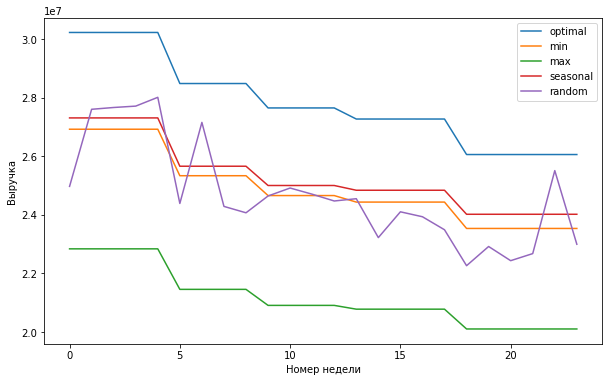

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(W), revenues_optimal, label='optimal')
plt.plot(range(W), revenues_min, label='min')
plt.plot(range(W), revenues_max, label='max')
plt.plot(range(W), revenues_seasonal, label='seasonal')
plt.plot(range(W), revenues_random, label='random')
plt.xlabel('Номер недели')
plt.ylabel('Выручка')
plt.legend(loc='upper right')

Как можно видеть на графике, выручка при ценах r_optimal оказывается максимальной из возможных вариантов.